In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import torch

In [2]:
torch.__version__

'2.0.1+cu117'

### Algorithm

1. Initialize the algorithm
   1. Construct the theoretical risk $\Xi(\theta) = E[\zeta(\omega, \theta)]$
   2. Define empirical risk $\Xi^n(\theta) = \frac{1}{n}\sum_i \zeta(\omega_i, \theta)$
   3. Define topology of neural network $\varphi(\theta)$
   4. Fix the initial vector of coefficients $\theta$
2. Train the machine, i.e. find $\theta$ that minimizes the empirical risk $\Xi^n(\theta)$:
   1. Simulate the model to produce data $\{\omega_i\}^n_{i=1}$ by using the decision rule $\varphi(\theta)$
   2. Construct gradient $\nabla\Xi^n(\theta) = ...$
   3. update the coefficients $\hat{\theta} = \theta = \lambda_k\nabla\Xi^n(\theta)$ and go to step 2.A, or End if $||\hat{\theta} - \theta || < \epsilon$ is satisfied.
3. Assess the accuracy of the constructed approximation on a new sample.

In [3]:
## Model equations and parameters

discount = 0.96
sigma_epsilon = 1
sigma_y = 0.1
rho = .8
r = 1.04
gamma = 2

T = 30 # number of periods used for forward looking estimation of lifetime utility
N = 5000 # number of sample trajectories used in training. "number of agents"

# shocks

epsilon = stats.norm(0,sigma_epsilon)

# dynamics

def w_prime(r,w,c,y):
    return r * (w - c) + math.e ** y

def c_upper_bound(w):
    return w

def c_lower_bound(w):
    return 0

def y_prime(rho, y, sigma_epsilon, epsilon):
    #print(rho, y, sigma_epsilon, epsilon)
    return rho * y + sigma_epsilon * epsilon


# reward
def u(c):
    return (c ** (1 - gamma) - 1) / ( 1 - gamma)


#### starting states....

### TODO: ergodic Normal y_0

y_0 = stats.norm(0, sigma_epsilon ** 2 / (1 - rho ** 2))

# not ergodic, as in the paper's first example
w_0 = stats.uniform()


######

states = (w_0, y_0)

state_transitions = (w_prime, y_prime)

## Step 1

In [4]:
## 1.C. Define topology of neural network -- for phi(theta), which gives the control variable c
## 1.D. Fix the initial vector of coefficients

NET_WIDTH = 32
    
class Net(torch.nn.Module):
    def __init__(self):
        # TODO: set this architecture
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(len(states), NET_WIDTH) # 
        self.hidden2 = torch.nn.Linear(NET_WIDTH, NET_WIDTH) # 
        self.output = torch.nn.Linear(NET_WIDTH, 1) # 1 neuron in output layer

    def forward(self, x):
        w = torch.unsqueeze(x[:,0],1)
        
        # SiLu because why not...
        x = torch.nn.functional.silu(self.hidden1(x))
        x = torch.nn.functional.silu(self.hidden2(x))
        x = self.output(x)
        
        # implement the constraints
        x = torch.sigmoid(x)
        multiplier = (c_upper_bound(w) - c_lower_bound(w))
        
        # normalize to Gamma region
        x = torch.mul(x,multiplier) + c_lower_bound(w) 

        return x
    
net = Net()

optimizer = torch.optim.Adam(net.parameters(), lr=0.01) # Using Adam

In [5]:
## 1.A. Theoretical risk
## 1.B. Empirical risk

In [6]:
# Computing lifetime utility requires:
# - using the policy phi
# - 'simulating forward' using the transition equations and the available shocks

def lifetime_utility(states_0, shocks_T, phi, discount):
    
    T = epsilon_T.shape[0]
    
    history = []
    c_history = []
    
    states_t = states_0
    
    reward = 0
    
    for t in range(T):
        history.append(states_t)

        c = phi(states_t)
        c_history.append(c)
        
        reward += u(c) * discount ** t
        
        # later this will be in an abstracted loop
        states_t_1 = {}
        
        # why do I need to squeeze?
        states_t_1['w'] = torch.squeeze(w_prime(r,states_t[t, 0],c,states_t[t,1]))
        states_t_1['y'] = y_prime(rho,states_t[t, 1],sigma_epsilon,epsilon_T[t,:]) 
        
        states_t = torch.stack(tuple(states_t_1.values()), dim = 1)
    
    history = torch.stack(history)

    return reward, history, c_history

def mean_lifetime_utility_loss(states_0, shocks_T, phi, discount):
    lu = lifetime_utility(states_0, shocks_T, phi, discount)[0]
    return - torch.mean(lu)

In [7]:
def plot_consumption(wealth_sample):

    R = 1000

    w_range = torch.linspace(
        wealth_sample.min(),
        wealth_sample.max(),
        R
    )

    plt.plot(
        w_range.detach().numpy(),
        net(torch.stack((
            w_range,
            torch.zeros(R) # setting y = 0, the mean
        ), dim=1)).detach().numpy()
    )
    plt.show()

## Step 2

In [8]:
### 2.A. Simulate model with \psi(\theta) to produce data omega_i

def sample_omega(states):
    epsilon_T = torch.FloatTensor(epsilon.rvs((T,N)))
    states_0_samples = np.array([dist_0.rvs(N) for dist_0 in states]).T
    states_0_tensor = torch.FloatTensor(states_0_samples)
    
    return states_0_tensor, epsilon_T

In [9]:
# Testing....
states_0_tensor, epsilon_T = sample_omega(states)

lifetime_utility(states_0_tensor, epsilon_T, net, discount)[0].shape
lifetime_utility(states_0_tensor, epsilon_T, net, discount)[1].shape

mean_lifetime_utility_loss(states_0_tensor, epsilon_T, net, discount)

tensor(inf, grad_fn=<NegBackward0>)

In [10]:
### B. Construct gradient \nabla \Xi^n (theta)
### C. Update the coefficients

def train_network(states_0, epsilon_T):
    for epoch in range(500):
        running_loss = 0.0
        optimizer.zero_grad()

        loss = mean_lifetime_utility_loss(states_0_tensor, epsilon_T, net, discount) 

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if epoch % 100 == 0:
            print("Epoch {}: Loss = {}".format(epoch, loss.detach().numpy()))


...as a loop...

Epoch 0: Loss = 14.083210945129395
Epoch 100: Loss = 18.26442527770996
Epoch 200: Loss = 17.17428970336914
Epoch 300: Loss = 14.665884017944336
Epoch 400: Loss = 12.139983177185059


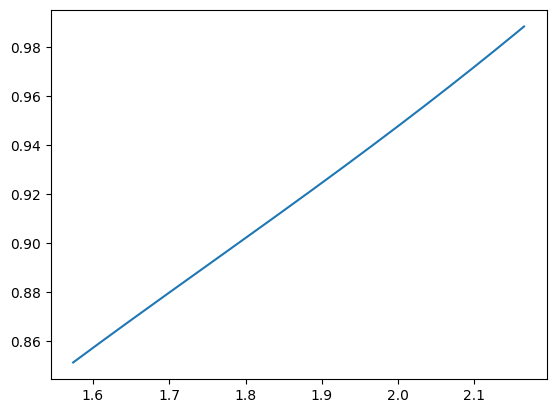

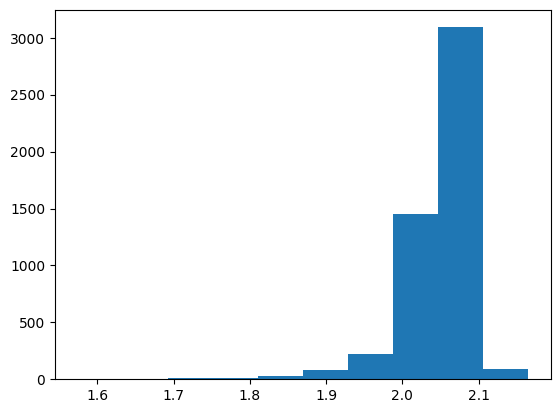

w distribution: 2.0519980658169317 0.048812092286790086
Epoch 0: Loss = -4.198672294616699
Epoch 100: Loss = -6.868741512298584
Epoch 200: Loss = -9.393716812133789
Epoch 300: Loss = 18.249752044677734
Epoch 400: Loss = 0.6861044764518738


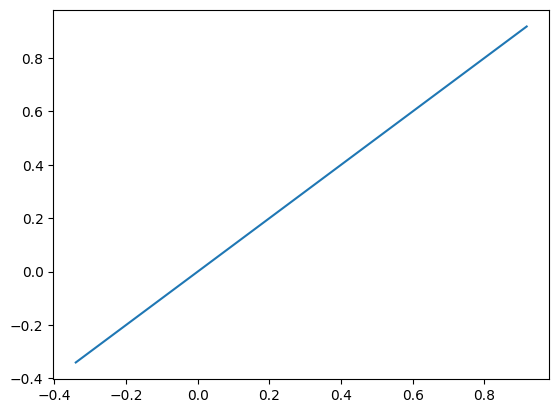

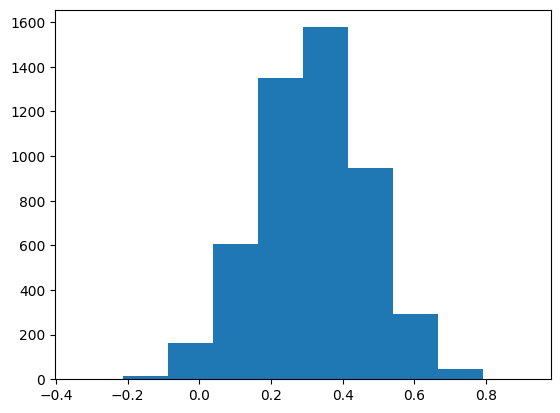

w distribution: 0.31538126083675166 0.15220038954109247
Epoch 0: Loss = -138.65907287597656
Epoch 100: Loss = -177.153076171875
Epoch 200: Loss = -175.9598846435547
Epoch 300: Loss = -176.6449737548828
Epoch 400: Loss = -183.3902130126953


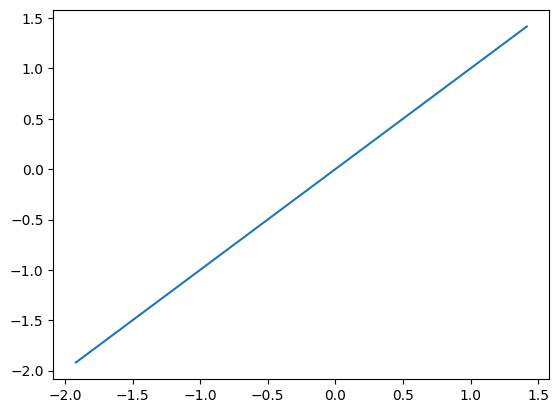

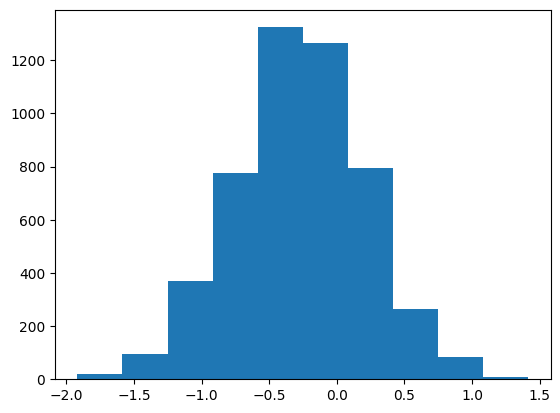

w distribution: -0.27414345839920884 0.4806308469665864
Epoch 0: Loss = -20.98345184326172
Epoch 100: Loss = -20.98345184326172
Epoch 200: Loss = -20.98345184326172
Epoch 300: Loss = -20.98345184326172
Epoch 400: Loss = -20.98345184326172


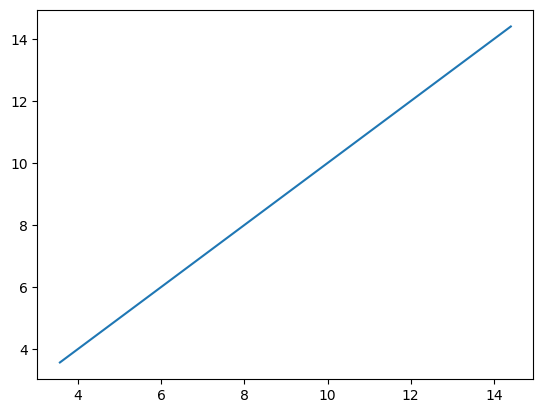

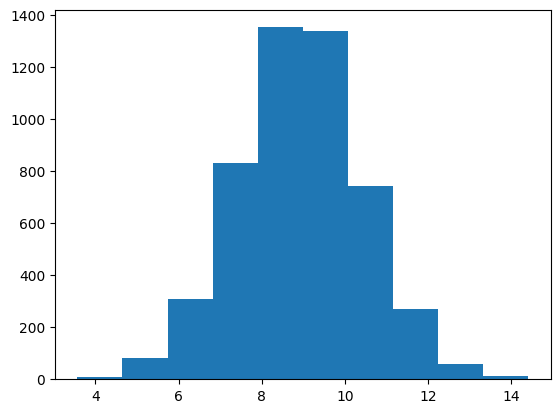

w distribution: 8.92487094332084 1.4930801857292793
Epoch 0: Loss = -10.86781120300293
Epoch 100: Loss = -10.86781120300293
Epoch 200: Loss = -10.86781120300293
Epoch 300: Loss = -10.86781120300293
Epoch 400: Loss = -10.867815971374512


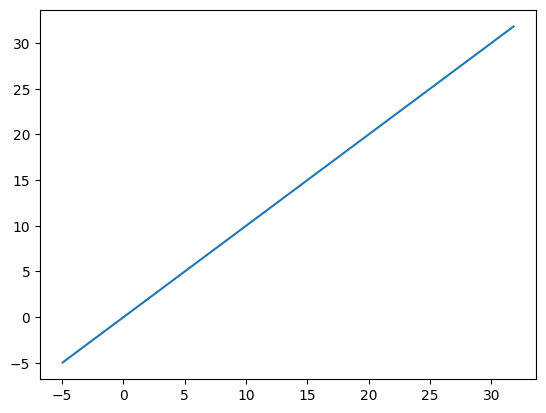

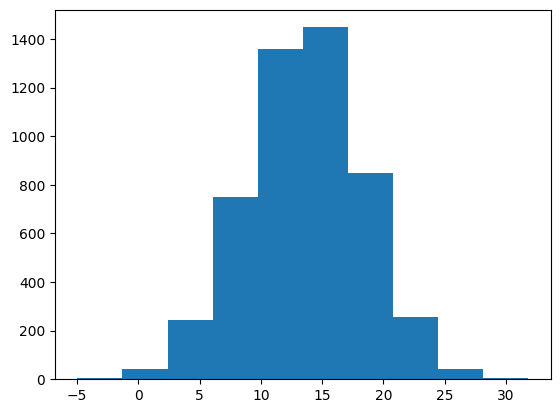

w distribution: 13.564474733023388 4.730401364323626
Epoch 0: Loss = -15.718771934509277
Epoch 100: Loss = -15.718771934509277
Epoch 200: Loss = -15.718771934509277
Epoch 300: Loss = -15.718771934509277
Epoch 400: Loss = -15.718771934509277


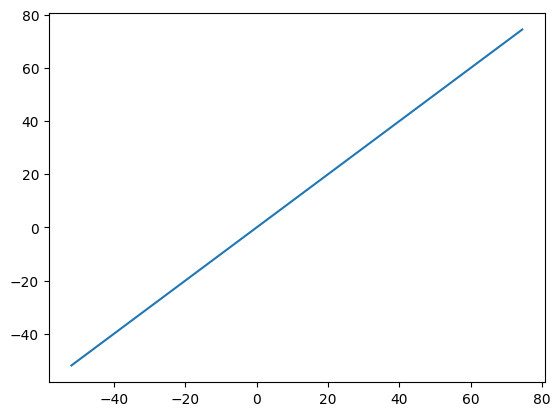

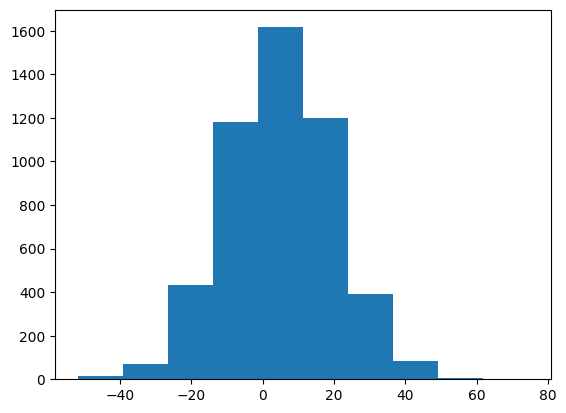

w distribution: 4.745308437973563 14.892654163262343
Epoch 0: Loss = -17.614910125732422
Epoch 100: Loss = -17.614910125732422
Epoch 200: Loss = -17.614910125732422
Epoch 300: Loss = -17.614910125732422
Epoch 400: Loss = -17.614910125732422


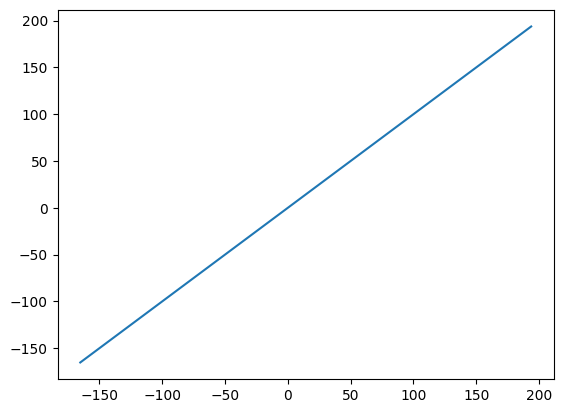

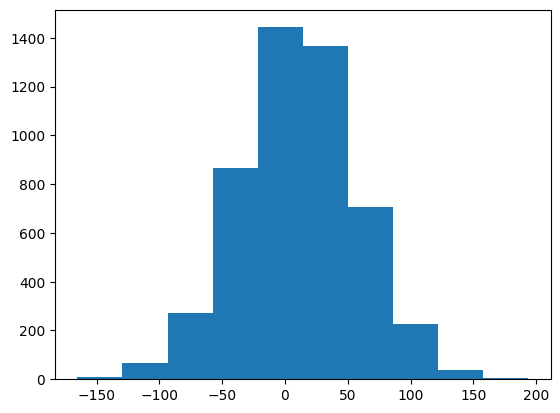

w distribution: 68292.76981885517 2344661560.518055
Epoch 0: Loss = -18.365299224853516
Epoch 100: Loss = -18.365299224853516
Epoch 200: Loss = -18.365299224853516
Epoch 300: Loss = -18.365299224853516
Epoch 400: Loss = -18.365299224853516


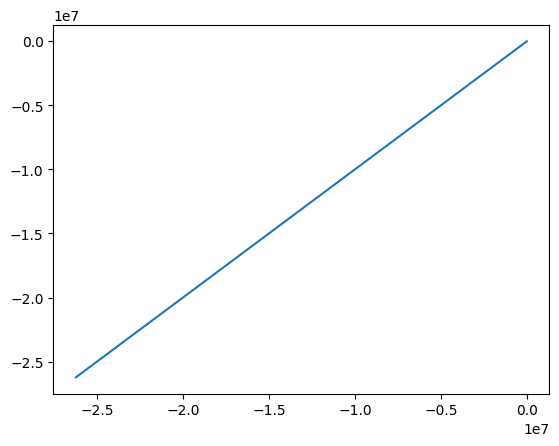

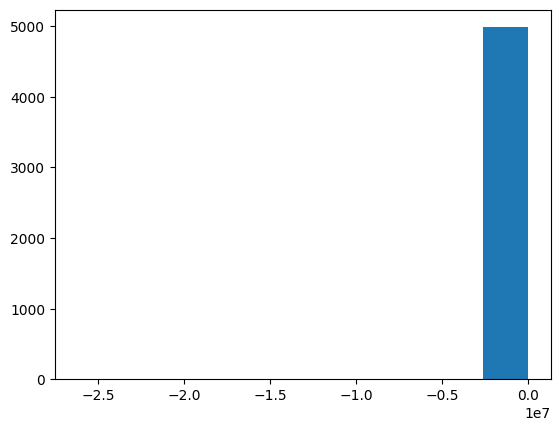

w distribution: -42546.3700773716 695685.6278436028
Epoch 0: Loss = -17.653400421142578
Epoch 100: Loss = -17.653400421142578
Epoch 200: Loss = -17.653400421142578


KeyboardInterrupt: 

In [11]:
states_x = [i for i in states]

for x in range(10):
    states_0_tensor, epsilon_T = sample_omega(states_x)
    
    train_network(states_0_tensor, epsilon_T)
    
    _, history, c_history = lifetime_utility(states_0_tensor, epsilon_T, net, discount)
    # there should be a less convoluted way to get the history and final state
    
    #import pdb; pdb.set_trace()
    
    final_wealth = history[T - 1,:,0].detach().numpy()

    plot_consumption(final_wealth)
    
    plt.hist(final_wealth)
    plt.show()
    
    params = stats.lognorm.fit(final_wealth)
    w_dist = stats.lognorm(params[0], loc = params[1], scale = params[2])
    
    print('w distribution:', w_dist.mean(), w_dist.std())
    
    #getting to the endogenous distribution of
    states_x = [0, states_x[1]]
    states_x[0] = w_dist